# Tutorial : 10x Visium(Breast Cancer)

test

In [1]:
# -*- coding: utf-8 -*-
import os
os.environ['R_CLI_ENCODING'] = 'UTF-8'
os.environ['R_HOME']="D:\\soft\\R-4.3.2"
import scanpy as sc
import numpy as np
import torch
from data import spatial_reconstruction
from sklearn.decomposition import PCA

from data import mclust_R
from data import seed_torch, load_data, cal_ari
import matplotlib.pyplot as plt
from models import GEN

In [2]:
adata=sc.read_h5ad("./151507.h5ad")

In [3]:
features_tensor = adata.obsm['embedding']
adata, conns = spatial_reconstruction(adata, n_neighbors = 10)

In [4]:
Tmat, edge_adj, adj, features, edge_features = load_data(conns, features_tensor)

e:\spaDCN\utils.py:349: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(indices, values, shape)


In [5]:
hidden_dim = 64
out_dim = 30
dropout_ratio = 0.1
learning_rate = 0.001
weight_decay = 5e-4

n_clusters = 7
a = 0.5
seed_torch(2025)
epochs = 10

In [6]:
domain = 'mclust' # louvain kmeans mclust leiden
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu' if torch.cuda.is_available() else 'cuda:0')
device

device(type='cuda', index=0)

In [7]:
model = GEN(features, edge_features, edge_adj, adj, Tmat, hidden_dim, out_dim, dropout_ratio, device, a)
model = model.to(device)
model.fit(features, edge_features, edge_adj, adj, Tmat, max_epochs=epochs, start=0.1, end=0.5, increment=0.05, init=domain, 
            n_clusters=n_clusters, pca_num=27, n_neighbors=10, opt="admin")
y_pred, pro, z1, q1=model.predict()

self.device cuda:0
Initializing cluster centers with mclust, n_clusters known


R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In Sys.setlocale("LC_ALL", "en_US.UTF-8") :
R[write to console]: 
 
R[write to console]:  using locale code page other than 936 may cause problems

Training Progress: 100%|██████████| 10/10 [01:09<00:00,  6.96s/it]


Train over.


In [8]:
adata, ARI, ARI_refine = cal_ari(z1, adata, domain, n_clusters,res=1)

mclust
pca_num:  24 class : 7
Adjusted rand index = 0.573
refine Adjusted rand index = 0.587


In [9]:
adata

AnnData object with n_obs × n_vars = 4226 × 33538
    obs: 'in_tissue', 'array_row', 'array_col', 'truth', 'pred', 'label_refined'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'Spatial_Net', 'hvg', 'label_refined_colors', 'log1p', 'neighbors', 'pca', 'pred_colors', 'spatial', 'spatial_reconstruction', 'umap'
    obsm: 'embedding', 'spatial'
    varm: 'PCs'
    layers: 'counts', 'log1p'
    obsp: 'connectivities', 'distances'

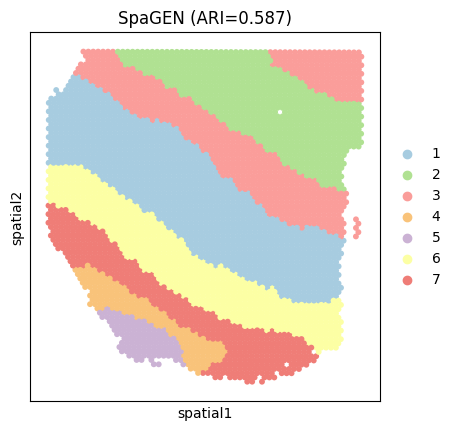

In [10]:
plot_color=["#A7CCE0","#B0E192","#FA9D9A","#F9C37A","#CBB2D4","#FCFFA4","#EF7D77"]
sc.pl.spatial(
    adata,
    img_key=None,
    color='label_refined',
    size=1.7,
    palette=plot_color,
    legend_loc='right margin',
    show=False,
    title=['SpaGEN (ARI=%.3f)'%ARI_refine]
)
plt.show()  # 现在显示图像